In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import expit


from edward.models import Normal, BernoulliWithSigmoidProbs, Bernoulli, InverseGamma, Empirical, StudentT
from observations import insteval

import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import logistic
import seaborn as sns


plt.style.use('ggplot')
ed.set_seed(42)

In [2]:
clusters = {0: dict(prob = 0.2, w = -0.5,   # cluster weight in logistic
                    sites = np.arange(6),     
                    site_probs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.5],
                    w_s =        [0.0, 0.0, 0.0, 5.0, 0.0, 0.0]),  # weights of sites in logistic
            1: dict(prob = 0.5, w = -1.0,  
                    sites = 6 + np.arange(3), 
                    site_probs = [0.1, 0.3, 0.6],
                    w_s        = [0.0, 0.0, 0.0]),                    
            2: dict(prob = 0.3, w = -0.2,  
                    sites = 9 + np.arange(3), 
                    site_probs = [0.3, 0.3, 0.4] ,
                    w_s =        [0.0, -4, 0.0 ]
                   )}


# num clusters
n_c = len(clusters)

# num sites
n_s = sum(list( map(len, list( map( lambda d: d['sites'], clusters.values()))))) # num sites

# site to cluster map
s2c = dict( [ (s,c) for c in range(n_c) for s in clusters[c]['sites']] )

# prob of each cluster occurring
p_c = [c['prob'] for c in clusters.values()]

# prob of site occurrence, within a cluster

p_s = ( [  dict( zip (d['sites'], d['site_probs']))  for d in clusters.values() ])

# "true" weights of clusters in logit model
w_c = np.array( [d['w'] for d in clusters.values()] )

# "true" weights of sites in logit model
w_s = np.concatenate( [d['w_s'] for d in clusters.values() ])

In [3]:

# logit for a site: sum of site-weight and its cluster-weight
def logit_site(site):
    return w_c[s2c[site]] + w_s[site]

# site response_rate
def rr_s(site):
    return logistic.cdf(logit_site(site))

In [4]:
def gen_prob_label(site):
    p = rr_s(site)
    return p, (np.random.uniform() < p)*1


def gen_row(cluster):
    site2prob = p_s[cluster]
    site_ids = list( site2prob.keys())
    probs = list(site2prob.values())
    site = site_ids[ np.random.choice(len(probs), 1, probs ) [0] ]
    prob, label = gen_prob_label(site)
    return [ cluster, site, prob, label ] 

def gen_data(N=100):
    clusters = np.random.choice(n_c, N, list(p_c))
    data = list(map(gen_row, clusters))
    df = pd.DataFrame( data, columns = ['cluster', 'site', 'prob', 'label'])
    features = dict(df[['cluster', 'site', 'prob']])
    labels = np.array(list( df['label']))
    return features, labels

def log_loss(labels, probs):
    return -np.mean(labels * np.log(probs) + (1-labels)*np.log(1-probs))

def rig(labels, probs):
    p = np.mean(labels)
    ent = -p*np.log(p) - (1-p)*np.log(1-p)
    loss = log_loss(labels, probs)
    return np.round(100*(ent - loss)/ent, 2)

# CAUTION: train, test size need to be same 
# because we hard-coded n_train_obs in the rand var defns below
x_train, y_train = gen_data(N=1000)
x_test, y_test = gen_data(N=1000)

c_train = x_train['cluster']
s_train = x_train['site']
n_obs_train = len(c_train)

c_test = x_test['cluster']
s_test = x_test['site']
n_obs_test = len(c_test)


In [5]:
# c_train = train[:,0]
# s_train = train[:,1]
# y_train = train[:,2]
# n_obs_train = train.shape[0]

# c_test = test[:,0]
# s_test = test[:,1]
# y_test = np.array(test[:,2]).astype(np.int32)
# n_obs_test = test.shape[0]

### Train + eval with MLE/TensorFlow

In [6]:

def input_fn(features, labels,  batch_size = 100, test = False):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if not test:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)


feature_cols = [#tf.feature_column.categorical_column_with_identity(key = 'cluster', num_buckets=n_c),
                tf.feature_column.categorical_column_with_identity(key = 'site', num_buckets = n_s)
               ]

classifier = tf.estimator.LinearClassifier(feature_columns=feature_cols, optimizer=tf.train.AdamOptimizer(learning_rate=0.01))

classifier.train(input_fn=lambda: input_fn(x_train, y_train), steps=3000)

# Evaluate the model.
eval_result = classifier.evaluate(input_fn=lambda: input_fn(x_test, y_test, test=True))

y_pred = classifier.predict(input_fn=lambda: input_fn(x_test, y_test, test=True))

probs = np.array( [yp['probabilities'][1] for yp in y_pred] )  # predicted probabilities for class[1] 





INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8t/pw3z265s66x05f3yfpynnr5s3_vhgw/T/tmpw4q6ksf7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c24c772b0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/8t/pw3z265s66x05f3yfpynnr5s3_vhgw/T/tmpw4q6ksf7/model.ckpt.
INFO:tensorflow:loss = 69.31474, step = 1
INFO:tensorflow:global_step/sec: 559.124
INFO:tensorflow:loss = 56.102158, step = 101 (0.180 sec)
INFO:tensorflow:global_step/sec: 813.212
INFO:tensorflow:loss = 56.0978, ste

### Max possile RIG and RIG from MLE


In [7]:

RIG = rig(y_test, probs)

# true logistic model probabilities 
true_probs = np.array(list(x_test['prob']))

# RIG if we knew the true logistic model
ideal_RIG = rig(y_test, true_probs)

print("%RIG-MLE = ", RIG, "%RIG-ideal = ", ideal_RIG)


%RIG-MLE =  12.16 %RIG-ideal =  12.79


### Set up Prior distributions

In [8]:
tf.reset_default_graph()

# Set up placeholders for the data inputs.
N = tf.placeholder(tf.int32, [])
s_ph = tf.placeholder(tf.int32, [None])
c_ph = tf.placeholder(tf.int32, [None])

# Set up random effects.
#sigma_c = tf.sqrt(tf.exp(tf.get_variable("sigma_c", [])))
eta_c = Normal(loc=tf.zeros(n_c), scale=0.01*tf.ones(n_c))#sigma_c*tf.ones(n_c))

w_s = Normal(loc=tf.zeros(n_s), scale=tf.ones(n_s))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
logits_traditional = Normal(loc=tf.gather(w_s,s_ph), scale=tf.ones(n_obs_train) )
logits_varying_intercept = Normal(loc=tf.gather(w_s,s_ph) + tf.gather(eta_c, c_ph), scale=tf.ones(n_obs_train))
y_traditional = Bernoulli(logits=logits_traditional)
y_varying_intercept = Bernoulli(logits=logits_varying_intercept)

In [9]:
qw_s_traditional = Normal(loc=tf.get_variable("qw_s_trad/loc", [n_s],initializer=tf.random_normal_initializer),
            scale=tf.nn.softplus(tf.get_variable("qw_s_trad/scale", [n_s], initializer=tf.random_normal_initializer)))
qb_traditional = Normal(loc=tf.get_variable("qb_trad/loc", [1], initializer=tf.random_normal_initializer),
            scale=tf.nn.softplus(tf.get_variable("qb_trad/scale", [1],initializer=tf.random_normal_initializer)))

qw_s_varying_intercept = Normal(loc=tf.get_variable("qw_s_vi/loc", [n_s],initializer=tf.random_normal_initializer),
            scale=tf.nn.softplus(tf.get_variable("qw_s_vi/scale", [n_s],initializer=tf.random_normal_initializer)))
qb_varying_intercept = Normal(loc=tf.get_variable("qb_vi/loc", [1],initializer=tf.random_normal_initializer),
            scale=tf.nn.softplus(tf.get_variable("qb_vi/scale", [1],initializer=tf.random_normal_initializer)))
q_eta_c = Normal(
    loc=tf.get_variable("q_eta_c/loc", [n_c]),
    scale=tf.nn.softplus(tf.get_variable("q_eta_c/scale", [n_c],initializer=tf.random_normal_initializer)))



latent_vars_traditional = {
    b : qb_traditional,
    w_s: qw_s_traditional,
    eta_c: q_eta_c}

latent_vars_varying_intercept = {
    b : qb_varying_intercept,
    w_s: qw_s_varying_intercept,
    eta_c: q_eta_c}

data_varying_intercept = {
    y_varying_intercept: y_train,
    s_ph: s_train,
    c_ph: c_train,
    N: n_obs_train
}

data_test_varying_intercept = {
    s_ph: s_test,
    c_ph: c_test,
    N: n_obs_test
}

data_traditional = {
    y_traditional: y_train,
    s_ph: s_train,
    N: n_obs_train
}

data_test_traditional = {
    s_ph: s_test,
    N: n_obs_test
}

In [10]:
inference_traditional = ed.KLqp(latent_vars_traditional, data_traditional)

inference_varying_intercept = ed.KLqp(latent_vars_varying_intercept, data_varying_intercept)

/Users/pchalasani/miniconda/envs/tfbrain/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/pchalasani/miniconda/envs/tfbrain/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [11]:
logits_traditional_post = ed.copy(logits_traditional, latent_vars_traditional)
logits_vi_post = ed.copy(logits_varying_intercept, latent_vars_varying_intercept)

In [12]:
y_test_traditional = ed.copy(y_traditional, latent_vars_traditional)
y_test_varying_intercept = ed.copy(y_varying_intercept, latent_vars_varying_intercept)

In [13]:
inference_varying_intercept.initialize(n_print=100, n_iter=10000)
tf.global_variables_initializer().run()

for i in range(inference_varying_intercept.n_iter):
  # Update and print progress of algorithm.
  info_dict = inference_varying_intercept.update()
  inference_varying_intercept.print_progress(info_dict)

10000/10000 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 646.674


In [14]:
inference_traditional.initialize(n_print=100, n_iter=10000)
tf.global_variables_initializer().run()

for i in range(inference_traditional.n_iter):
  # Update and print progress of algorithm.
  info_dict = inference_traditional.update()
  inference_traditional.print_progress(info_dict)

10000/10000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 666.521


In [15]:
def plot_param(w, data=None, n_samples=100, title=''):
    ax = plt.axes()
    if data is None:
        plot_vals = w.sample(n_samples).eval().squeeze()
    else:
        plot_vals = w.sample(n_samples,).eval(data).squeeze()
    try:
        D = plot_vals.shape[1]
        for i  in range(D):
            sns.kdeplot(plot_vals[:,i], ax=ax)
    except IndexError:
        sns.kdeplot(plot_vals,color='green',ax=ax)
    ax.set_title(title)

def plot_posterior(w, data=None, n_samples=2, probs=False, title=''):
    ax = plt.axes()
    if probs is True:
        plot_vals = expit(w.sample(n_samples).eval(data).squeeze())
    else:
        plot_vals = w.sample(n_samples,).eval(data).squeeze()
    D = plot_vals.shape[0]
    for i  in range(D):     
        sns.kdeplot(plot_vals[i,:],ax=ax)
    ax.set_title(title)
    return plot_vals

### Traditional Logistic - Parameter Distribution


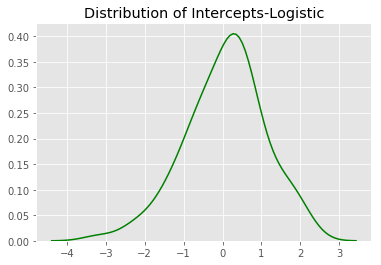

In [16]:
plot_param(qb_traditional, title='Distribution of Intercepts-Logistic')

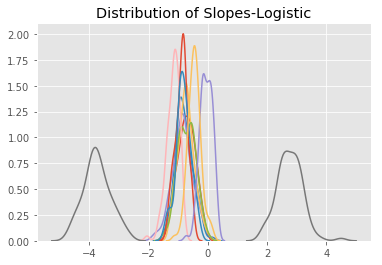

In [17]:
plot_param(qw_s_traditional, title='Distribution of Slopes-Logistic')

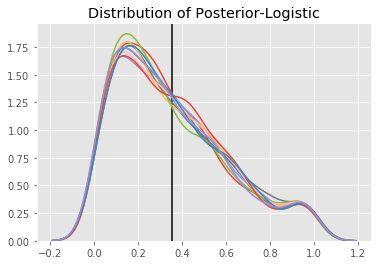

In [18]:
a=plot_posterior(logits_traditional_post, data_traditional, n_samples=10,probs=True,
                 title='Distribution of Posterior-Logistic')
plt.vlines(y_train.sum()/n_obs_train,0,2)

### RIG with Traditional Bayesian Logistic

In [19]:
z_trad = logits_traditional_post.sample(1000).eval(data_test_traditional).mean(axis=0)
probs_trad = logistic.cdf(z_trad)
rig_trad = rig(y_test, probs_trad)
print("%RIG-trad = ", rig_trad)

%RIG-trad =  11.51


### RIG with Varying-intercept Bayesian

In [20]:
z_vi = logits_vi_post.sample(100).eval(data_test_varying_intercept).mean(axis=0)
probs_vi = logistic.cdf(z_vi)
rig_vi = rig(y_test, probs_vi)
print("%RIG-VI = ", rig_vi)

%RIG-VI =  -38.72


### MLE Estimates

In [21]:
from sklearn.linear_model import LogisticRegression
def one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

lr = LogisticRegression(fit_intercept=True)
lr.fit(one_hot(s_train, n_s), y_train)
print(lr.coef_)
print(lr.intercept_)

[[-0.02302078 -0.13537729 -0.2130906   2.91451119 -0.07282496 -0.03494879
  -0.44820518 -0.21197196 -0.14644834  0.52546588 -2.90475641  0.17751573]]
[-0.5731515]


### Bayesian Estimates

In [22]:
w_s_traditional= qw_s_traditional.sample(1000).eval().mean(axis=0)
b_traditional  = qb_traditional.sample(1000).eval().mean()
print(w_s_traditional)
print(b_traditional)

[-0.67311406 -0.7967479  -0.89523196  2.8133323  -0.7430407  -0.6882859
 -1.2015084  -0.93123466 -0.82188255 -0.03834323 -3.7421944  -0.44689083]
0.051474508


### Mixed Effect - Cluster Varying Intercept

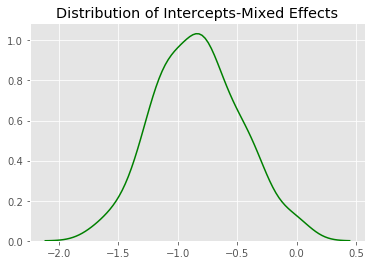

In [23]:
plot_param(qb_varying_intercept, title='Distribution of Intercepts-Mixed Effects')

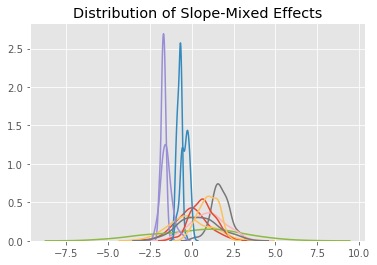

In [24]:
plot_param(qw_s_varying_intercept, title='Distribution of Slope-Mixed Effects')

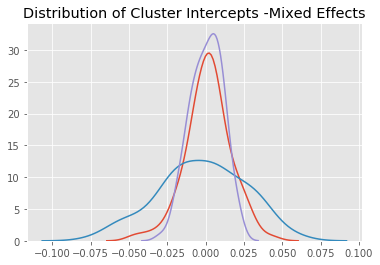

In [25]:
plot_param(q_eta_c,title='Distribution of Cluster Intercepts -Mixed Effects')

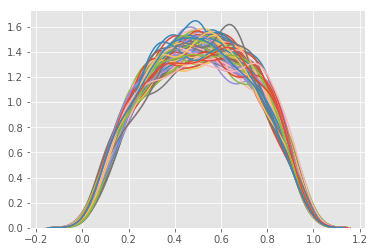

In [26]:
a=plot_posterior(logits_varying_intercept, data_varying_intercept, n_samples=100, probs=True)